In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Day1_Create the  population & employment data in MSA region

## <font color='#F7DC6F '>Read Historical Delineation Files of the MSA regions</font>

In [3]:
msa_us = pd.read_excel('list1_2020.xls',dtype={'FIPS State Code': 'object', 'FIPS County Code': 'object', 'CBSA Code':'object', 'CSA Code':'object'},header=2)
msa_us = msa_us[msa_us['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area'].reset_index(drop=True)
msa_us['fips_couty'] = msa_us['FIPS State Code'] + msa_us['FIPS County Code']
msa_us = msa_us[['CBSA Code','CBSA Title','CSA Code','CSA Title','Metropolitan/Micropolitan Statistical Area','County/County Equivalent','fips_couty','Central/Outlying County']]

## <font color='#F7DC6F '>Read Geometry Data at Tract Level in U.S Mainland regions</font>

In [4]:
# import pandas as pd
# import geopandas as gpd

# tracts_us = pd.DataFrame()

# exclude_states = ['02', '15', '72', '78', '60', '66', '69', '74', '75', '79', '81', '84', '86', '87', '89', '71']

# for i in range(80):
#     state = str(i).zfill(2)
#     if state in exclude_states:
#         continue
#     try:
#         url = 'https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_'+state+'_tract.zip'
#         tracts = gpd.read_file(url)
#         tracts_us = pd.concat([tracts_us, tracts])
#         print(f"Processed state: {state}")
#     except Exception as e:
#         print(f"Error processing state {state}: {e}")
#         continue

# tracts_us.plot()

<Axes: >

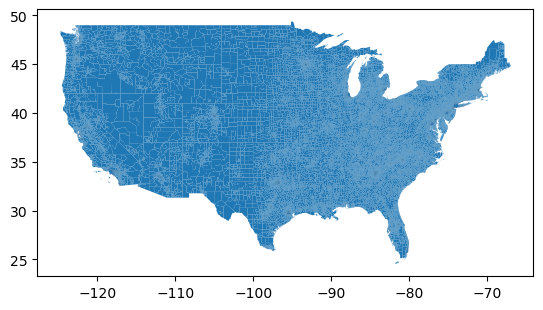

In [5]:
# read the API from the tiger line at Tract level
tracts_us = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_tract_500k.zip')
# filter the outlines to only include the US states
exclude_states = ['02', '15', '72', '78', '60', '66', '69', '74', '75', '79', '81', '84', '86', '87', '89', '71']
tracts_us = tracts_us[~tracts_us['STATEFP'].isin(exclude_states)].reset_index(drop=True)
tracts_us['fips_couty'] = tracts_us['STATEFP'] + tracts_us['COUNTYFP']
tracts_us = tracts_us[['fips_couty','GEOID','NAMELSAD','STUSPS','STATE_NAME','NAMELSADCO','ALAND','geometry']]

tracts_us.plot()

## <font color='#F7DC6F '>Merge MSA data into Tract Geometry Data</font>

In [6]:
msa_us_merge = msa_us.merge(tracts_us, on='fips_couty', how='left')
msa_us_merge = msa_us_merge.dropna()

msa_us_merge = gpd.GeoDataFrame(msa_us_merge, geometry='geometry',crs=tracts_us.crs)

## <font color='#F7DC6F '>Read population and employment data by API </font>

In [7]:
# read the API key
import json
# import census API
from census import Census
from us import states

with open("census_api_key_Houpu.json", 'r') as f:
    key_file = f.read()
my_api_key = json.loads(key_file)['key']


def fetch_census_data(fields):
    """
    Fetches census data for the specified fields in 2020 for all counties and tracts across the U.S.

    Parameters:
    - api_key: str, Census API key.
    - fields: list of str, the specific columns to retrieve.
    """
    
    c = Census(my_api_key)
    data = c.acs5.state_county_tract(fields=fields,
                                        state_fips="*",  # Fetch the fips code across the us
                                        county_fips="*",  # fetch all the counties
                                        tract="*",  # fetch all the tracts
                                        year=2020)
    
    # transform the data into a DataFrame
    df = pd.DataFrame(data)
    
    # add a new columns to store the year
    df['year'] = 2020

    return df

In [8]:
import json
import pandas as pd
from census import Census
from us import states

# Read Census API key
with open("census_api_key_Houpu.json", 'r') as f:
    key_file = f.read()
my_api_key = json.loads(key_file)['key']

def fetch_census_data(fields):
    """
    Fetches census data for the specified fields in 2020 for all counties and tracts across the U.S.

    Parameters:
    - api_key: str, Census API key.
    - fields: list of str, the specific columns to retrieve.
    """
    
    c = Census(my_api_key)
    df = pd.DataFrame()
    
    for state in states.STATES:
        state_fips = state.fips
        data = c.acs5.state_county_tract(fields=fields,
                                         state_fips=state_fips,
                                         county_fips="*",  # fetch all the counties
                                         tract="*",  # fetch all the tracts
                                         year=2020)
        
        state_df = pd.DataFrame(data)
        df = pd.concat([df, state_df], ignore_index=True)
    
    df['year'] = 2020
    
    return df

In [9]:
fields = ['NAME', 'B01003_001E']  # B01003_001E:total population
pop_20 = fetch_census_data(fields)
pop_20 = pop_20.rename(columns={'B01003_001E':'tot_pop'})
pop_20['GEOID'] = pop_20['state'] + pop_20['county'] + pop_20['tract']

In [10]:
fields = ['NAME', 'B23001_001E']  # B23001_001:total employment for the 16 years old and over
emp_20 = fetch_census_data(fields)
emp_20 = emp_20.rename(columns={'B23001_001E':'tot_emp'})
emp_20['GEOID'] = emp_20['state'] + emp_20['county'] + emp_20['tract']

## <font color='#F7DC6F '>Integrate the data into MSA geomotry data</font>

In [11]:
msa_us_merge = msa_us_merge.merge(pop_20[['GEOID','tot_pop']], on='GEOID', how='left').merge(emp_20[['GEOID','tot_emp']], on='GEOID', how='left').dropna().reset_index(drop=True)

In [12]:
msa_us_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59954 entries, 0 to 59953
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   CBSA Code                                   59954 non-null  object  
 1   CBSA Title                                  59954 non-null  object  
 2   CSA Code                                    59954 non-null  object  
 3   CSA Title                                   59954 non-null  object  
 4   Metropolitan/Micropolitan Statistical Area  59954 non-null  object  
 5   County/County Equivalent                    59954 non-null  object  
 6   fips_couty                                  59954 non-null  object  
 7   Central/Outlying County                     59954 non-null  object  
 8   GEOID                                       59954 non-null  object  
 9   NAMELSAD                                    59954 non-null  obje

<Axes: >

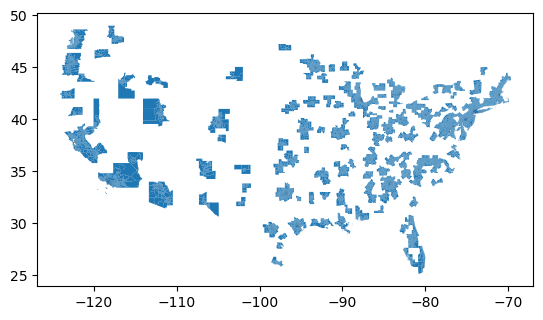

In [13]:
msa_us_merge.plot()

[MSA map published by United States Census Bureau](https://www.census.gov/geographies/reference-maps/2020/geo/cbsa.html)

# Day2&3_Delineate the Polymetric and Monometric analysis by LISA and GWR

## <font color='#F7DC6F '>Delineate the Main Center by Local Moran'I</font>

In [14]:
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.explore import esda
from pysal.lib import weights
from esda.moran import Moran
from libpysal.weights import Queen, KNN
from numpy.random import seed

from splot import esda as esdaplot

In [15]:
msa_us_merge['CSA Title'].unique().size

152

### LISA by Total Population

In [16]:
msa_us_merge = msa_us_merge.to_crs(epsg=3857)

# create a new datafram to store the results of lisa
lisa_results_pop = pd.DataFrame()

for msa_id, msa_data in msa_us_merge.groupby('CSA Title'):

    w = KNN.from_dataframe(msa_data, k=8)
    w.transform = 'R'
    
    lisa = esda.moran.Moran_Local(msa_data["tot_pop"], w)
    
    msa_data['LISA'] = lisa.Is
    msa_data['LISA_p'] = lisa.p_sim
    msa_data['LISA_q'] = lisa.q  # Quadrant information
    
    lisa_results_pop = pd.concat([lisa_results_pop, msa_data])
    
lisa_results_pop = gpd.GeoDataFrame(lisa_results_pop, geometry='geometry', crs="EPSG:3857")
lisa_results_pop['sig'] = (lisa_results_pop['LISA_p'] < 0.05) * 1

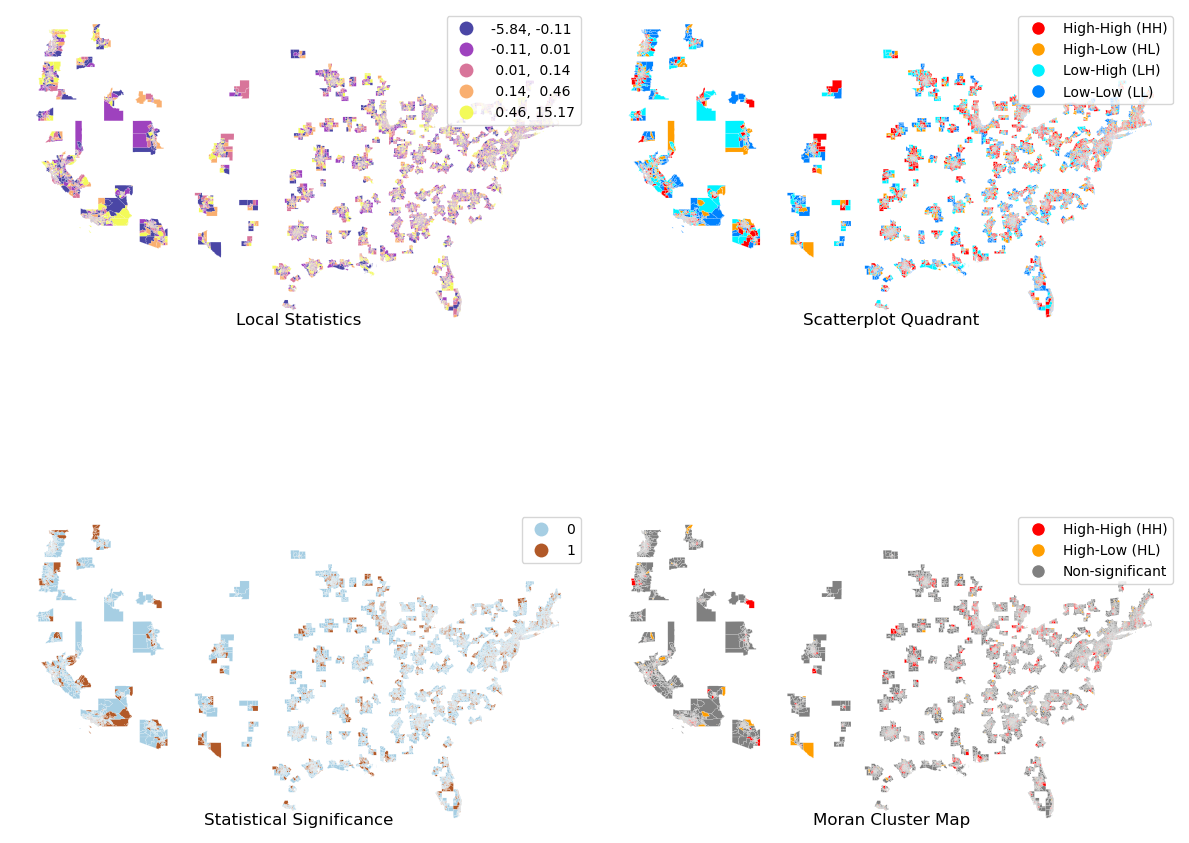

In [17]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
lisa_results_pop.plot(
    column="LISA",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=axs[0],
)

# Subplot 2 #
# Quadrant categories
quadrant_cmap = {
    1: '#FF0000',    # HH
    2: '#00F2FF',   # LH
    3: '#0082FF',  # LL
    4: '#FF9E00'  # HL
}

# Apply the colormap to the LISA_q column
lisa_results_pop['quadrant_color'] = lisa_results_pop['LISA_q'].map(quadrant_cmap)

# Create a custom legend
quadrant_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=quadrant_cmap[i], markersize=10, label=label)
                    for i, label in zip([1, 4, 2, 3], ['High-High (HH)', 'High-Low (HL)', 'Low-High (LH)','Low-Low (LL)'])]

lisa_results_pop.plot(
    color=lisa_results_pop['quadrant_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[1],
)
axs[1].legend(handles=quadrant_handles)

# Subplot 3 #
# Significance map
lisa_results_pop.plot(
    column="sig",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=axs[2],
)

# Subplot 4 #
# Cluster map
cluster_colors = {0: 'grey', 1: '#FF0000', 4: '#FF9E00'}
lisa_results_pop['cluster_color'] = np.where(
    (lisa_results_pop['sig'] == 1) & (lisa_results_pop['LISA_q'].isin([1, 4])),
    lisa_results_pop['LISA_q'].map(cluster_colors),
    'grey'
)

# Create a custom legend for clusters
cluster_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[i], markersize=10, label=label)
                   for i, label in zip([1, 4, 0], ['High-High (HH)', 'High-Low (HL)', 'Non-significant'])]

lisa_results_pop.plot(
    color=lisa_results_pop['cluster_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[3],
)
axs[3].legend(handles=cluster_handles)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [21]:
# lisa_results_pop.to_file('lisa_results_pop.shp')

### LISA by Total Employment

In [22]:
msa_us_merge = msa_us_merge.to_crs(epsg=3857)

# create a new datafram to store the results of lisa
lisa_results_emp = pd.DataFrame()

for msa_id, msa_data in msa_us_merge.groupby('CSA Title'):

    w = KNN.from_dataframe(msa_data, k=8)
    w.transform = 'R'
    
    lisa = esda.moran.Moran_Local(msa_data["tot_emp"], w)
    
    msa_data['LISA'] = lisa.Is
    msa_data['LISA_p'] = lisa.p_sim
    msa_data['LISA_q'] = lisa.q  # Quadrant information
    
    lisa_results_emp = pd.concat([lisa_results_emp, msa_data])
    
lisa_results_emp = gpd.GeoDataFrame(lisa_results_emp, geometry='geometry', crs="EPSG:3857")
lisa_results_emp['sig'] = (lisa_results_emp['LISA_p'] < 0.05) * 1

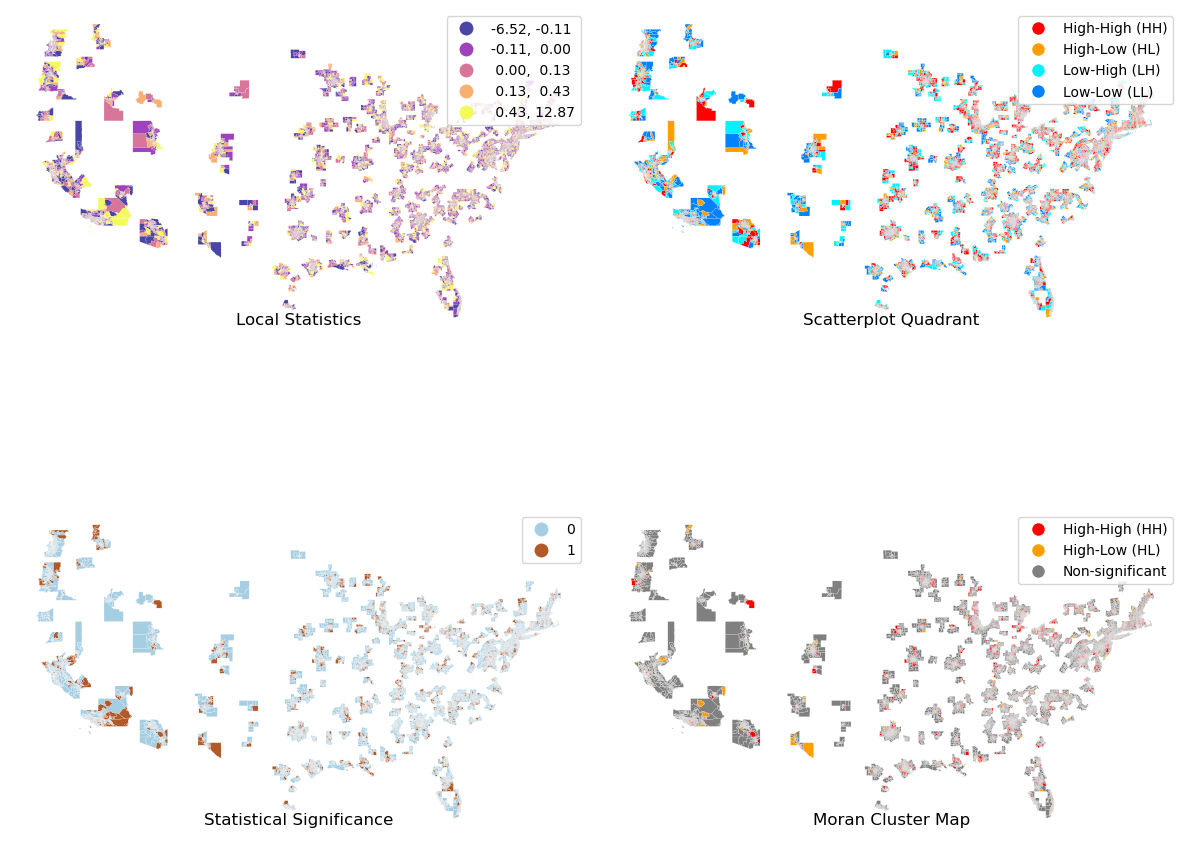

In [23]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
lisa_results_emp.plot(
    column="LISA",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=axs[0],
)

# Subplot 2 #
# Quadrant categories
quadrant_cmap = {
    1: '#FF0000',    # HH
    2: '#00F2FF',   # LH
    3: '#0082FF',  # LL
    4: '#FF9E00'  # HL
}

# Apply the colormap to the LISA_q column
lisa_results_emp['quadrant_color'] = lisa_results_emp['LISA_q'].map(quadrant_cmap)

# Create a custom legend
quadrant_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=quadrant_cmap[i], markersize=10, label=label)
                    for i, label in zip([1, 4, 2, 3], ['High-High (HH)', 'High-Low (HL)', 'Low-High (LH)','Low-Low (LL)'])]

lisa_results_emp.plot(
    color=lisa_results_emp['quadrant_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[1],
)
axs[1].legend(handles=quadrant_handles)

# Subplot 3 #
# Significance map
lisa_results_emp.plot(
    column="sig",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=axs[2],
)

# Subplot 4 #
# Cluster map
cluster_colors = {0: 'grey', 1: '#FF0000', 4: '#FF9E00'}
lisa_results_emp['cluster_color'] = np.where(
    (lisa_results_emp['sig'] == 1) & (lisa_results_emp['LISA_q'].isin([1, 4])),
    lisa_results_emp['LISA_q'].map(cluster_colors),
    'grey'
)

# Create a custom legend for clusters
cluster_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[i], markersize=10, label=label)
                   for i, label in zip([1, 4, 0], ['High-High (HH)', 'High-Low (HL)', 'Non-significant'])]

lisa_results_emp.plot(
    color=lisa_results_emp['cluster_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[3],
)
axs[3].legend(handles=cluster_handles)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [24]:
# lisa_results_emp.to_file('lisa_results_emp.shp')